<a href="https://colab.research.google.com/github/Esther-Wagatwe/Detecting-melanona-using-Machine-Learning/blob/main/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install isic-cli
!isic image download --limit 2000 myimages/

import pandas as pd
import os
import shutil

# Load metadata from the CSV file
metadata_path = 'myimages/metadata.csv'
metadata = pd.read_csv(metadata_path)

# Set the output directories
output_dir = 'myimages/'
benign = os.path.join(output_dir, 'benign')
malignant = os.path.join(output_dir, 'malignant')

# Create output directories if they don't exist
os.makedirs(benign, exist_ok=True)
os.makedirs(malignant, exist_ok=True)

# Iterate through the metadata and move images to the respective directories
for index, row in metadata.iterrows():
    image_name = row['isic_id'] + '.JPG'  # Assuming the image filenames are in the 'name' column
    source_path = os.path.join(output_dir, image_name)
    #print(f"Source File Exists: {os.path.exists(source_path)}")


    if row['benign_malignant'] == 'benign':
        target_dir = benign
    elif row['benign_malignant'] == 'malignant':
        target_dir = malignant
    else:
        continue  # Skip if the label is not 'benign' or 'malignant'

    target_path = os.path.join(target_dir, image_name)

    shutil.move(source_path, target_path)

# Print the number of images in each directory
print(f"Number of Benign Images: {len(os.listdir(benign))}")
print(f"Number of Malignant Images: {len(os.listdir(malignant))}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.4 MB/s eta 0:00:00
If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 2,000 images to myimages/.
Successfully wrote 2,000 metadata records to myimages/metadata.csv.
Successfully wrote attributions to myimages/attribution.txt.
Successfully wrote 2 license(s) to myimages/licenses.
Number of Benign Images: 1322
Number of Malignant Images: 678


In [10]:
!ls myimages/
!mv myimages/licenses/ .
!ls myimages/

attribution.txt  benign  malignant  metadata.csv
mv: cannot stat 'myimages/licenses/': No such file or directory
attribution.txt  benign  malignant  metadata.csv


In [9]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Set directory paths
benign_dir = 'myimages/benign'
malignant_dir = 'myimages/malignant'

# Define image size and batch size
image_size = (224, 224)  # Adjust according to the model's input size
batch_size = 32

# Load the images and labels
dataset = tf.keras.utils.image_dataset_from_directory(
    'myimages/',
    labels='inferred',
    class_names=['benign', 'malignant'],
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

# Concatenate all batches to get the complete dataset
X, y = [], []
for batch_X, batch_y in dataset:
    X.append(batch_X.numpy())
    y.append(batch_y.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1337)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1337)


Found 2000 files belonging to 2 classes.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input

# Preprocess images for the model
X_train_preprocessed = preprocess_input(X_train)
X_val_preprocessed = preprocess_input(X_val)
X_test_preprocessed = preprocess_input(X_test)

In [12]:
!pip install tensorflow_hub

In [13]:
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense


# Load the model from Kaggle
vit_model =hub.KerasLayer("https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-b32-classification/versions/1")

# Create input layer
inputs = Input(shape=(224, 224, 3))

#Use the ViT model as a Keras layer
model = hub.KerasLayer(vit_model)(inputs)

# Add Dense layers on top of the ViT output
dense_layer_1 = Dense(256, activation='relu')(model)
dense_layer_2 = Dense(128, activation='relu')(dense_layer_1)

output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1000)              88224232  
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88513513 (337.65 MB)
Trainable params: 289281 (1.10 MB)
Non-trainable params: 88224232 (336.55 MB)
_________________________________________________________________


In [14]:
history = model.fit(X_train_preprocessed, y_train, epochs=10, validation_data=(X_val_preprocessed, y_val))


Epoch 1/10
38/38 [==============================] - 318s 8s/step - loss: 0.7203 - accuracy: 0.6725 - val_loss: 0.5220 - val_accuracy: 0.7450
Epoch 2/10
38/38 [==============================] - 295s 8s/step - loss: 0.5147 - accuracy: 0.7283 - val_loss: 0.5115 - val_accuracy: 0.7100
Epoch 3/10
38/38 [==============================] - 296s 8s/step - loss: 0.4796 - accuracy: 0.7483 - val_loss: 0.4818 - val_accuracy: 0.7700
Epoch 4/10
38/38 [==============================] - 294s 8s/step - loss: 0.4817 - accuracy: 0.7375 - val_loss: 0.5222 - val_accuracy: 0.7475
Epoch 5/10
38/38 [==============================] - 293s 8s/step - loss: 0.4689 - accuracy: 0.7508 - val_loss: 0.5210 - val_accuracy: 0.7025
Epoch 6/10
38/38 [==============================] - 293s 8s/step - loss: 0.4647 - accuracy: 0.7425 - val_loss: 0.5330 - val_accuracy: 0.6725
Epoch 7/10
38/38 [==============================] - 292s 8s/step - loss: 0.4414 - accuracy: 0.7708 - val_loss: 0.4870 - val_accuracy: 0.7375
Epoch 8/10
38

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

13/13 [==============================] - 70s 5s/step - loss: 0.4443 - accuracy: 0.7650
Test Accuracy: 76.50%
Test loss: 44.43%


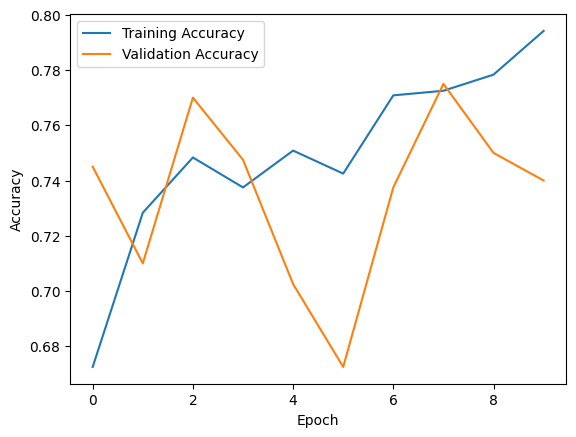

In [16]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


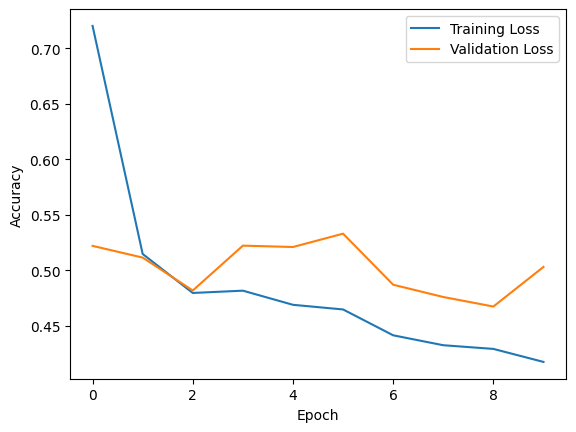

In [17]:
# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
